In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D,GlobalMaxPooling1D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('convertcsv.csv')
data = dataset[['text','aspectCategories/aspectCategory/0/_polarity']]
#data = dataset.rename(index=str, columns={ 0: "text", 6: "sentiment"})
newdata = data.dropna()
newdata.isnull().sum()
newdata = newdata.rename(columns={'aspectCategories/aspectCategory/0/_polarity': 'sentiment'})

In [3]:
newdata['text'] = newdata['text'].apply(lambda x: x.lower())
print(newdata[ newdata['sentiment'] == 'positive'].size)
print(newdata[ newdata['sentiment'] == 'negative'].size)
print(newdata[ newdata['sentiment'] == 'neutral'].size)
print(newdata[ newdata['sentiment'] == 'conflict'].size)
newdata = newdata[newdata.sentiment != "conflict"]
newdata = newdata[newdata.sentiment != "neutral"]
newdata.head(5)

3484
1316
954
334


,text,sentiment
0,but the staff was so horrible to us.,negative
1,"to be completely fair, the only redeeming fact...",positive
2,"the food is uniformly exceptional, with a very...",positive
3,where gabriela personaly greets you and recomm...,positive
4,"for those that go once and don't enjoy it, all...",positive


In [4]:
#Make number of classes balanced 
num_of_categories = 700
shuffled = newdata.reindex(np.random.permutation(newdata.index))
po = shuffled[shuffled['sentiment'] == 'positive'][:num_of_categories]
ng = shuffled[shuffled['sentiment'] == 'negative'][:num_of_categories]

concated = pd.concat([po,ng], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
print(concated.size)

print(concated[ concated['sentiment'] == 'positive'].size)
print(concated[ concated['sentiment'] == 'negative'].size)


2716
1400
1316


In [5]:
import spacy
nlp = spacy.load('en')

sentiment_terms = []
for review in nlp.pipe(concated['text']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
concated['sentiment_terms'] = sentiment_terms
concated.head(10)

,text,sentiment,sentiment_terms
1023,"the $300 bill was a bit steep, but the experie...",negative,steep great
662,i got enough reasons to keep coming back!!!,positive,get come
404,this place is worth going even if only for the...,positive,worth go
523,we will be back.,positive,
723,dinner took almost 4 hours without any lag time.,negative,take
925,when we notified him that he didn't mention th...,negative,notify mention apologize let know good
1246,"the decor is really blah, and not at all hip o...",negative,blah
136,we were very surprised by how good the food wa...,positive,surprised good sunday
5,"the service is excellent, the decor is great, ...",positive,excellent great delicious come large
298,"solid wine list, knowledgeable staff, friendly...",positive,solid knowledgeable friendly adventurous chang...


In [6]:
max_fatures = 6000
MAX_SEQUENCE_LENGTH = 30
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(concated['sentiment_terms'].values)
X = tokenizer.texts_to_sequences(concated['sentiment_terms'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

import pickle

# saving
with open('review_token.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(max_fatures, embedding_dim, input_length = X.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 128)           768000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

In [8]:
Y = pd.get_dummies(concated['sentiment']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]
(1086, 30) (1086, 2)
(272, 30) (272, 2)


In [9]:
batch_size = 32
sentiment_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs = 10, batch_size=batch_size, verbose = 2)

Train on 1086 samples, validate on 272 samples
Epoch 1/10
 - 2s - loss: 0.6943 - acc: 0.4959 - val_loss: 0.6930 - val_acc: 0.5257
Epoch 2/10
 - 1s - loss: 0.6904 - acc: 0.5470 - val_loss: 0.6897 - val_acc: 0.5294
Epoch 3/10
 - 1s - loss: 0.6571 - acc: 0.6137 - val_loss: 0.6516 - val_acc: 0.7096
Epoch 4/10
 - 1s - loss: 0.5237 - acc: 0.7970 - val_loss: 0.5401 - val_acc: 0.7224
Epoch 5/10
 - 1s - loss: 0.3559 - acc: 0.8656 - val_loss: 0.5328 - val_acc: 0.7574
Epoch 6/10
 - 1s - loss: 0.2807 - acc: 0.9056 - val_loss: 0.5631 - val_acc: 0.7849
Epoch 7/10
 - 1s - loss: 0.2348 - acc: 0.9084 - val_loss: 0.5843 - val_acc: 0.7408
Epoch 8/10
 - 1s - loss: 0.2068 - acc: 0.9088 - val_loss: 0.6532 - val_acc: 0.7757
Epoch 9/10
 - 1s - loss: 0.1882 - acc: 0.9245 - val_loss: 0.6952 - val_acc: 0.7831
Epoch 10/10
 - 1s - loss: 0.1555 - acc: 0.9438 - val_loss: 0.7583 - val_acc: 0.7812


<Figure size 432x288 with 0 Axes>

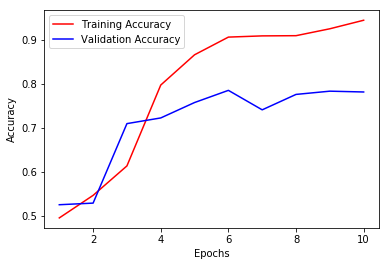

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = sentiment_model.history['acc']
val_acc = sentiment_model.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, color = 'red', label='Training acc')
plt.plot(epochs, val_acc, color = 'blue', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])

plt.figure()

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_predict = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in Y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_predict ]

matrix = confusion_matrix(y_test_non_category, y_predict_non_category)
print(matrix)
#print(yhat_classes)
#yhat_classes = yhat_classes[:, 0]
#print(yhat_classes)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_non_category, y_predict_non_category)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_non_category, y_predict_non_category)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_non_category, y_predict_non_category)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_non_category, y_predict_non_category)
print('F1 score: %f' % f1)

[[101  28]
 [ 33 110]]
Accuracy: 0.775735
Precision: 0.797101
Recall: 0.769231
F1 score: 0.782918


In [29]:
new_review = nlp("Lacks diversity in workforce")

new_review_sentiment_terms = []
new_review_sentiment_terms.append(' '.join([token.lemma_ for token in new_review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))

print(new_review_sentiment_terms)
#vectorizing the tweet by the pre-fitted tokenizer instance
review = tokenizer.texts_to_sequences(new_review_sentiment_terms)
#padding the tweet to have exactly the same shape as `embedding_2` input
review = pad_sequences(review, maxlen=30, dtype='int32', value=0)
#print(review)
sentiment = model.predict(review,batch_size=1,verbose = 2)[0]
print(sentiment)
score = np.max(sentiment)
print(score)
position = np.argmax(sentiment)
if position == 0 and score > 0.55:
    print('negative')
elif position == 1 and score > 0.55:
    print('positive')
elif position == 0 or position == 1 and score >= 0.45 and score <=0.55:
    print('neutral')

['lack']
[0.9809325  0.02918736]
0.9809325
negative


In [111]:
from keras.models import load_model

model.save('sentiment_model_new_cnn_spacy.h5')